## First easy example of convolution

In [1]:
using Images, TestImages, PyPlot, BenchmarkTools

INFO: Recompiling stale cache file /Users/davidbuchacaprats/.julia/lib/v0.6/TestImages.ji for module TestImages.


In [2]:
img = testimage("lena_gray");
img1 = Gray.(img);

INFO: Recompiling stale cache file /Users/davidbuchacaprats/.julia/lib/v0.6/QuartzImageIO.ji for module QuartzImageIO.


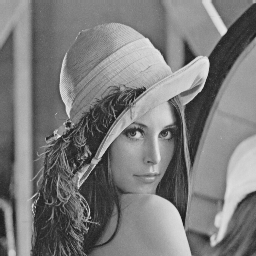

In [3]:
img1

In [4]:
size(img1)

(256, 256)

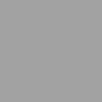

In [5]:
img1[1:3,1:3]

#### Apply Kernel

Let us consider the kernel 

```
1 0 -1
1 0 -1
1 0 -1
```

We would like to apply it at every possible position in the image. 

This mask is overlapped into the original image and the elementwise product of the values is computed.
Then it is added to get the value of the output.



In [6]:
K = [[1,1,1]  [0,0,0]  [-1,-1,-1]]

3×3 Array{Int64,2}:
 1  0  -1
 1  0  -1
 1  0  -1

In [7]:
X = Float32.(img1);

In [8]:
# This is the value that has to go to the Out[1,1]
sum(X[1:3,1:3].*K)

-1.1920929f-7

In [9]:
# This is the value that has to go to the Out[1,2]
sum(X[2:4,2:4].*K)

0.007843137f0

In [10]:
function convolution_2d_1(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    
    output = zeros(im_width-f, im_height-f)
    for w in 1:im_width-f
        for h in 1:im_height-f
            output[w,h] = sum(X[w:w+f-1, h:h+f-1] .* K)
        end
    end
    
    return output
end

convolution_2d_1 (generic function with 1 method)

In [11]:
@time Xconv = convolution_2d_1(X,K);

  0.139696 seconds (303.13 k allocations: 21.982 MiB, 7.03% gc time)


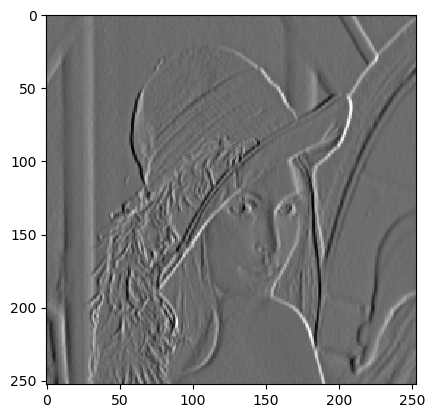

PyObject <matplotlib.image.AxesImage object at 0x12a9f2e90>

In [12]:
PyPlot.imshow(Xconv, cmap="gray")

In [13]:
@benchmark convolution_2d_1(X,K)

BenchmarkTools.Trial: 
  memory estimate:  20.02 MiB
  allocs estimate:  256038
  --------------
  minimum time:     8.877 ms (0.00% GC)
  median time:      11.139 ms (17.99% GC)
  mean time:        11.167 ms (16.80% GC)
  maximum time:     16.228 ms (15.57% GC)
  --------------
  samples:          447
  evals/sample:     1

### Improving speed Using views

In [14]:
function convolution_2d_2(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    
    output = zeros(im_width-f, im_height-f)
    for w in 1:im_width-f
        for h in 1:im_height-f
            output[w,h] = sum(view(X,w:w+f-1, h:h+f-1) .* K)
        end
    end
    
    return output
end

convolution_2d_2 (generic function with 1 method)

In [15]:
@benchmark convolution_2d_2(X,K)

BenchmarkTools.Trial: 
  memory estimate:  8.30 MiB
  allocs estimate:  64011
  --------------
  minimum time:     4.599 ms (0.00% GC)
  median time:      4.880 ms (0.00% GC)
  mean time:        5.400 ms (8.62% GC)
  maximum time:     9.804 ms (19.15% GC)
  --------------
  samples:          923
  evals/sample:     1

In [16]:
Xconv2 = convolution_2d_2(X,K);

In [17]:
Xconv == Xconv2

true

### Change `X[w:w+f-1, h:h+f-1] .* K` by a double for loop


In [64]:
w = 10
h = 1
f = 3
K

3×3 Array{Int64,2}:
 1  0  -1
 1  0  -1
 1  0  -1

In [20]:
X[w:w+f-1, h:h+f-1]

3×3 Array{Float32,2}:
 0.615686  0.623529  0.619608
 0.611765  0.607843  0.607843
 0.623529  0.607843  0.6     

In [48]:
print(X[w,h],  "\t", X[w+1,h],   "\t", X[w+2,h],"\n")
print(X[w,h+1],"\t", X[w+1,h+1], "\t", X[w+2,h+1],"\n")
print(X[w,h+2],"\t", X[w+1,h+2], "\t", X[w+2,h+2] )

0.6156863	0.6117647	0.62352943
0.62352943	0.60784316	0.60784316
0.61960787	0.60784316	0.6

In [49]:
K

3×3 Array{Int64,2}:
 1  0  -1
 1  0  -1
 1  0  -1

In [57]:
aux = 0.
l = 1

for col in h:h+f-1
    for row in w:w+f-1
    #println("w",w)
        #println("row: ", row, "\tcol: ", col, "\t ", X[row,col])
        println("X[$row, $col] = ", X[row,col], "  \tK[$l] = ",K[l])
        aux += X[row,col]*K[l]
        l +=1
    end
end

X[10, 1] = 0.6156863  	K[1] = 1
X[11, 1] = 0.6117647  	K[2] = 1
X[12, 1] = 0.62352943  	K[3] = 1
X[10, 2] = 0.62352943  	K[4] = 0
X[11, 2] = 0.60784316  	K[5] = 0
X[12, 2] = 0.60784316  	K[6] = 0
X[10, 3] = 0.61960787  	K[7] = -1
X[11, 3] = 0.60784316  	K[8] = -1
X[12, 3] = 0.6  	K[9] = -1


In [59]:
aux

0.023529410362243652

In [63]:
sum(X[w:w+f-1, h:h+f-1] .*K) == aux

true

#### Write a function

In [65]:
function convolution_2d_3(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    
    output = zeros(im_width-f, im_height-f)
    for w in 1:im_width-f
        for h in 1:im_height-f
            aux = 0.
            l = 1
            for col in h:h+f-1
                for row in w:w+f-1
                    aux += X[row,col]*K[l]
                    l +=1
                end
            end
            output[w,h] = aux
        end
    end
    
    return output

end

convolution_2d_3 (generic function with 1 method)

In [85]:
Xconv3 = convolution_2d_3(X,K);

In [86]:
@benchmark convolution_2d_3(X,K)

BenchmarkTools.Trial: 
  memory estimate:  500.20 KiB
  allocs estimate:  2
  --------------
  minimum time:     1.170 ms (0.00% GC)
  median time:      1.387 ms (0.00% GC)
  mean time:        1.506 ms (2.96% GC)
  maximum time:     5.392 ms (67.24% GC)
  --------------
  samples:          3305
  evals/sample:     1

In [84]:
sum(Xconv3 .- Xconv)

-6.796419620513916e-5

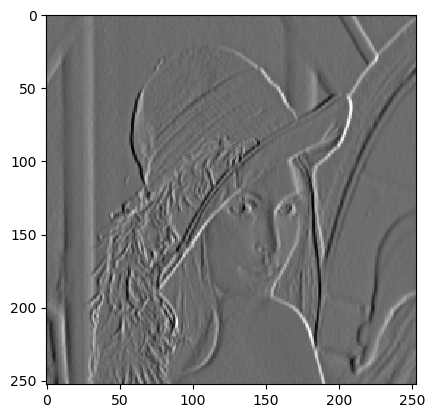

PyObject <matplotlib.image.AxesImage object at 0x12ad3a950>

In [103]:
PyPlot.imshow(Xconv3, cmap="gray")

### Inbounds

In [94]:
function convolution_2d_4(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    output = zeros(eltype(X), im_width-f, im_height-f)
    @inbounds  for w in 1:im_width-f
        for h in 1:im_height-f
            aux = 0.
            l = 1
            for col in h:h+f-1
                for row in w:w+f-1
                    aux += X[row,col]*K[l]
                    l +=1
                end
            end
            output[w,h] = aux
        end
    end
    return output
end

convolution_2d_4 (generic function with 1 method)

In [95]:
Xconv4 = convolution_2d_4(X,K);

In [96]:
@benchmark convolution_2d_4(X,K)

BenchmarkTools.Trial: 
  memory estimate:  250.14 KiB
  allocs estimate:  2
  --------------
  minimum time:     847.414 μs (0.00% GC)
  median time:      1.073 ms (0.00% GC)
  mean time:        1.162 ms (2.53% GC)
  maximum time:     7.048 ms (69.42% GC)
  --------------
  samples:          4263
  evals/sample:     1

In [129]:
sum(Xconv3 .- Xconv)

-6.796419620513916e-5

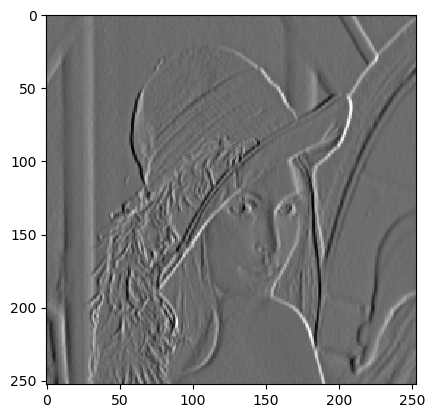

PyObject <matplotlib.image.AxesImage object at 0x137b67990>

In [158]:
PyPlot.imshow(Xconv4, cmap="gray")

### Benchmark vs `Images.imfilter`

  0.010364 seconds (98 allocations: 1.803 MiB, 78.06% gc time)


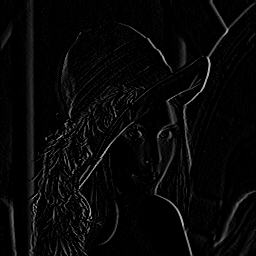

In [153]:
@time gx = imfilter(img, centered([1 0 -1]))

In [157]:
@benchmark imfilter(img, centered([1 0 -1]))

BenchmarkTools.Trial: 
  memory estimate:  1.80 MiB
  allocs estimate:  74
  --------------
  minimum time:     967.167 μs (0.00% GC)
  median time:      1.420 ms (0.00% GC)
  mean time:        1.699 ms (12.53% GC)
  maximum time:     8.923 ms (66.91% GC)
  --------------
  samples:          2920
  evals/sample:     1

In [148]:
Xconv4_imfilter = Float32.(gx);

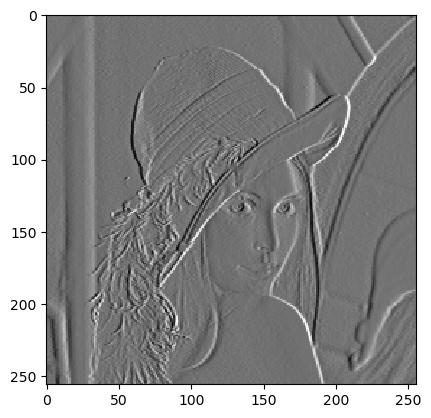

PyObject <matplotlib.image.AxesImage object at 0x13784a390>

In [150]:
PyPlot.imshow(Xconv4_imfilter, cmap="gray")

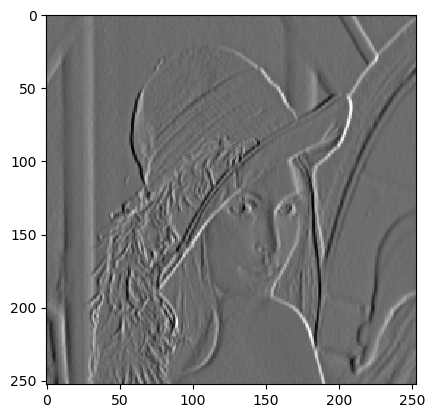

PyObject <matplotlib.image.AxesImage object at 0x137980150>

In [151]:
PyPlot.imshow(Xconv4, cmap="gray")

#### Acess cols of X[row, col] where col moves

In [117]:
function convolution_2d_5(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    output = zeros(eltype(X), im_width-f, im_height-f)
    @inbounds  for w in 1:im_width-f
        for h in 1:im_height-f
            aux = 0.
            l = 1
            for row in w:w+f-1
                for col in h:h+f-1
                    aux += X[row,col]*K[l]
                    l +=1
                end
            end
            output[w,h] = aux
        end
    end
    return output
end

convolution_2d_5 (generic function with 1 method)

In [125]:
@benchmark convolution_2d_5(X,K)

BenchmarkTools.Trial: 
  memory estimate:  250.14 KiB
  allocs estimate:  2
  --------------
  minimum time:     812.624 μs (0.00% GC)
  median time:      980.441 μs (0.00% GC)
  mean time:        1.108 ms (2.64% GC)
  maximum time:     7.551 ms (65.92% GC)
  --------------
  samples:          4475
  evals/sample:     1

In [128]:
Xconv5 = convolution_2d_5(X,K);

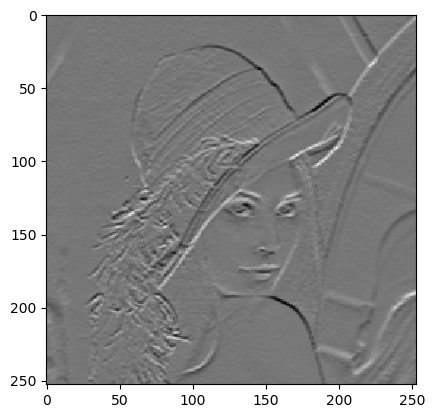

PyObject <matplotlib.image.AxesImage object at 0x13697e650>

In [127]:
PyPlot.imshow(Xconv5, cmap="gray")

### Write convolution in the code

Problem: this does not generalize to different kernel sizes

In [114]:

function convolution_2d_6(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    output = zeros(eltype(X), im_width-f, im_height-f)
    @inbounds  for w in 1:im_width-f
        for h in 1:im_height-f            
            a = X[w,h]  * K[1] + X[w+1,h]  * K[2] + X[w+2,h]* K[3] +
                X[w,h+1]* K[4] + X[w+1,h+1]* K[5] + X[w+2,h+2]* K[6] +
                X[w,h+2]* K[7] + X[w+1,h+2]* K[8] + X[w+2,h+2]* K[9]
        end
    end
    return output
end

convolution_2d_6 (generic function with 1 method)

In [115]:
@benchmark convolution_2d_6(X,K)

BenchmarkTools.Trial: 
  memory estimate:  7.08 MiB
  allocs estimate:  448065
  --------------
  minimum time:     4.133 ms (0.00% GC)
  median time:      5.205 ms (0.00% GC)
  mean time:        5.372 ms (9.64% GC)
  maximum time:     10.949 ms (28.38% GC)
  --------------
  samples:          928
  evals/sample:     1